In [1413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors

In [1414]:
df = pd.read_csv('taxi_trip_pricing.csv')
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


Basic Data Analyses

In [1415]:
df.shape

(1000, 11)

In [1416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [1417]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

In [1418]:
df.duplicated().sum()

np.int64(0)

Exploratory Data Analyses

In [1419]:
cat_cols = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
num_cols = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [1420]:
df.isnull().sum()

Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64

In [1421]:
cat_cols = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

for cols in cat_cols:
    cat_vals = df[cols].value_counts()
    print(f"value count of {cols} :")
    print(cat_vals)
    print("-"*40)

value count of Time_of_Day :
Time_of_Day
Afternoon    421
Morning      283
Evening      203
Night         93
Name: count, dtype: int64
----------------------------------------
value count of Day_of_Week :
Day_of_Week
Weekday    705
Weekend    295
Name: count, dtype: int64
----------------------------------------
value count of Traffic_Conditions :
Traffic_Conditions
Low       447
Medium    371
High      182
Name: count, dtype: int64
----------------------------------------
value count of Weather :
Weather
Clear    717
Rain     227
Snow      56
Name: count, dtype: int64
----------------------------------------


In [1422]:
df = pd.get_dummies(df, columns=['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather'], drop_first=True)

Trip_Price               3.844391
Trip_Distance_km         2.302844
Per_Km_Rate              0.086028
Passenger_Count          0.078532
Per_Minute_Rate          0.064101
Trip_Duration_Minutes    0.019447
Base_Fare               -0.008297
dtype: float64


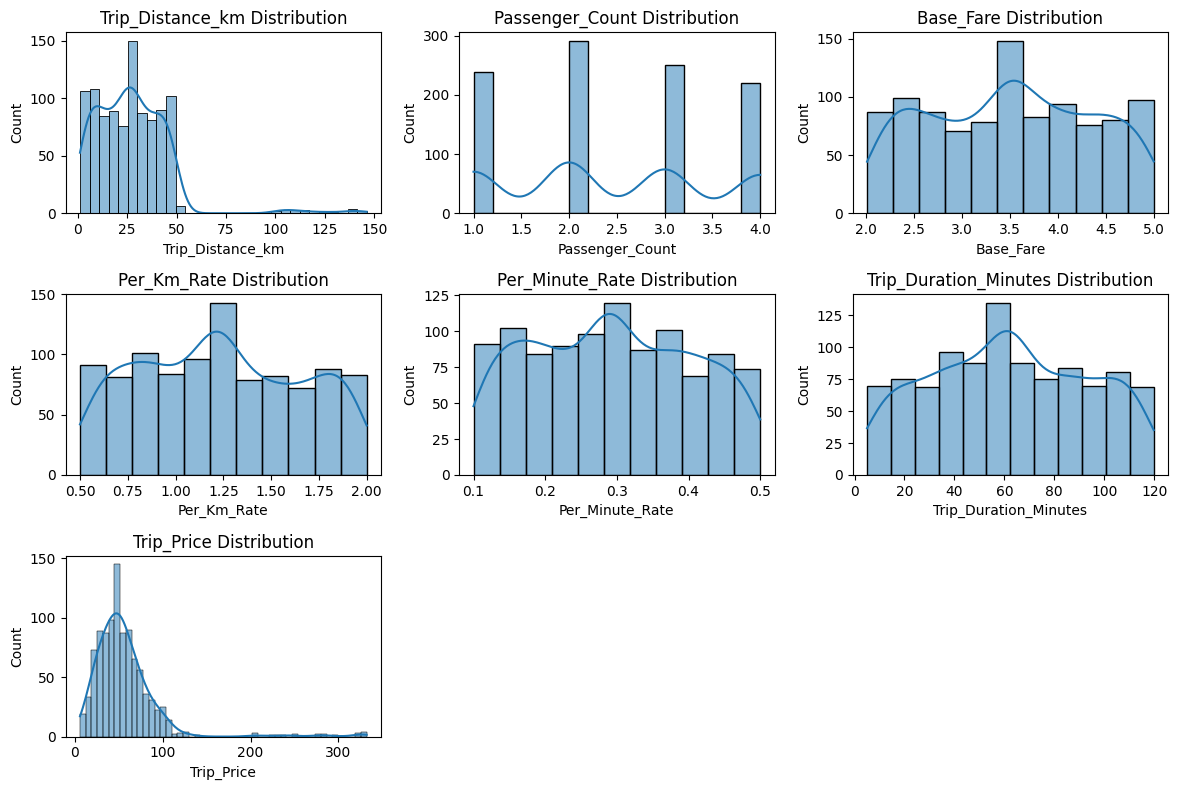

In [1423]:
num_cols = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

skew = df[num_cols].skew().sort_values(ascending=False)
print(skew)

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

Trip_Price         -0.009769
Trip_Distance_km   -0.786009
dtype: float64


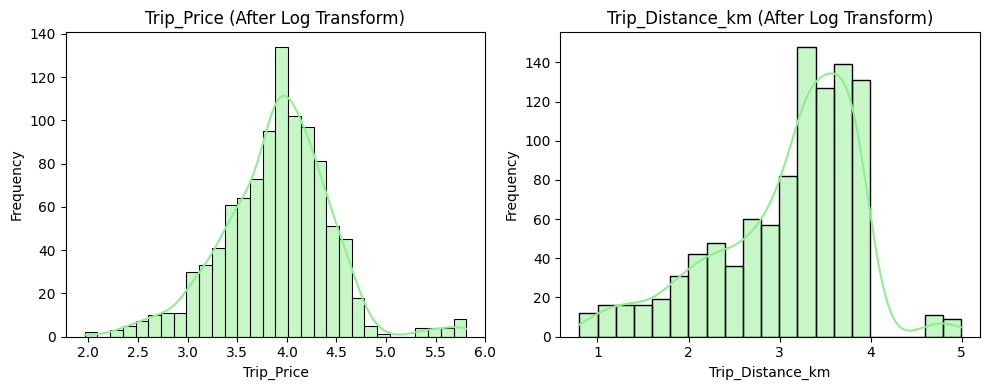

In [1424]:
skewed_cols = ['Trip_Price', 'Trip_Distance_km']

df[skewed_cols] = df[skewed_cols].apply(np.log1p)

skew_aft = df[skewed_cols].skew()
print(skew_aft)

plt.figure(figsize=(10, 4))
for i, col in enumerate(skewed_cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], kde=True, color='lightgreen')
    plt.title(f'{col} (After Log Transform)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Trip_Price               37
Trip_Distance_km         19
Per_Km_Rate               0
Passenger_Count           0
Per_Minute_Rate           0
Trip_Duration_Minutes     0
Base_Fare                 0
dtype: int64


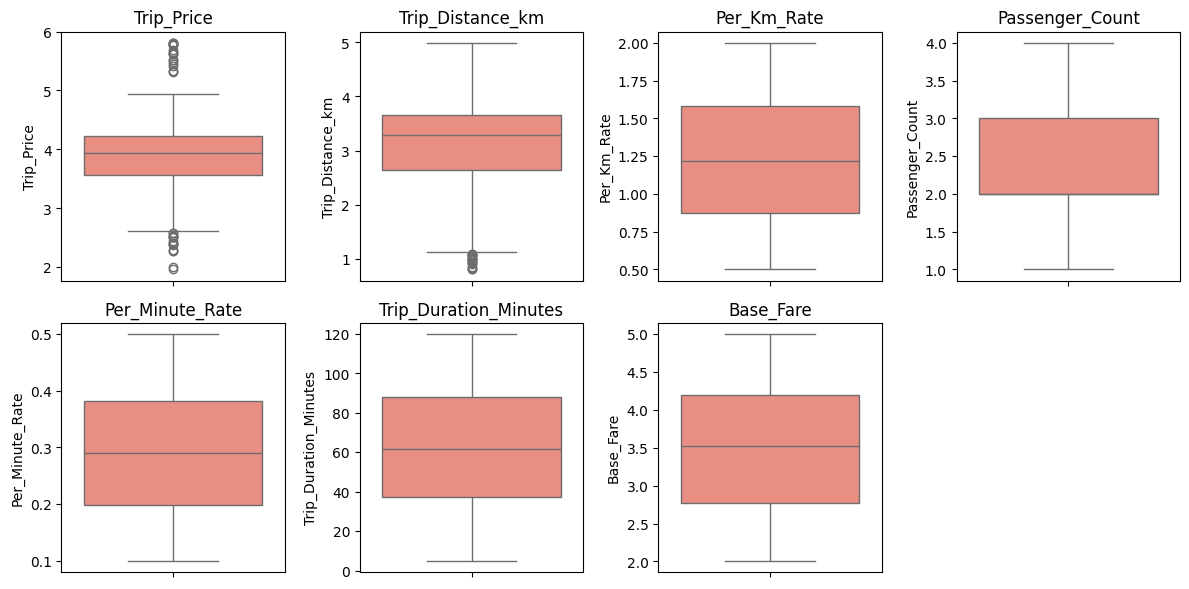

In [1425]:
num_cols = ['Trip_Price', 'Trip_Distance_km', 'Per_Km_Rate', 'Passenger_Count', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Base_Fare']

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR)))
print(outliers.sum().sort_values(ascending=False))

plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col], color='salmon')
    plt.title(col)
plt.tight_layout()
plt.show()

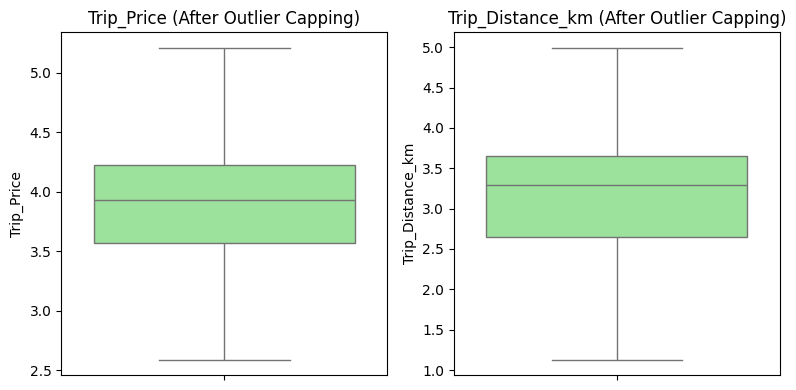

In [1426]:
for col in ['Trip_Price', 'Trip_Distance_km']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

plt.figure(figsize=(8,4))
for i, col in enumerate(['Trip_Price', 'Trip_Distance_km'], 1):
    plt.subplot(1, 2, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'{col} (After Outlier Capping)')
plt.tight_layout()
plt.show()

In [1427]:
features = ['Trip_Distance_km', 'Per_Km_Rate', 
            'Passenger_Count', 'Per_Minute_Rate', 
            'Trip_Duration_Minutes', 'Base_Fare',
            *[col for col in df.columns if any(x in col for x in ['Time_of_Day_', 'Day_of_Week_', 'Traffic_Conditions_', 'Weather_'])]
           ]

X = df[features]

In [1428]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [1429]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

KMeans Clustering

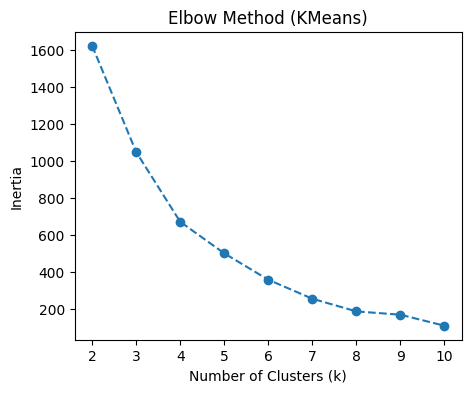

In [1430]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(5,4))
plt.plot(K, inertia, 'o--')
plt.title('Elbow Method (KMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [1431]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

print("KMeans Silhouette Score:", silhouette_score(X_pca, kmeans_labels))

KMeans Silhouette Score: 0.48280799177127415


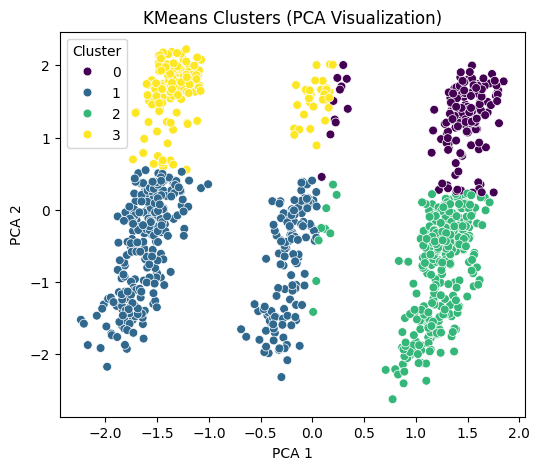

In [1432]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='viridis', s=40)
plt.title('KMeans Clusters (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [1433]:
df['KMeans_Cluster'] = kmeans_labels

kmeans_descriptions = {
    0: "Morning commuters with calm traffic and lower fares.",
    1: "Typical city rides under normal conditions.",
    2: "Evening/night rides with faster movement and slightly higher prices.",
    3: "Longer trips with moderate fares, possibly suburban routes."
}

df['KMeans_Description'] = df['KMeans_Cluster'].map(kmeans_descriptions)

In [1434]:
print("Cluster Counts:\n", df['KMeans_Cluster'].value_counts(), "\n")

print("Cluster Descriptions:")
for cluster, desc in kmeans_descriptions.items():
    print(f"Cluster {cluster}: {desc}")

Cluster Counts:
 KMeans_Cluster
1    383
2    308
0    159
3    150
Name: count, dtype: int64 

Cluster Descriptions:
Cluster 0: Morning commuters with calm traffic and lower fares.
Cluster 1: Typical city rides under normal conditions.
Cluster 2: Evening/night rides with faster movement and slightly higher prices.
Cluster 3: Longer trips with moderate fares, possibly suburban routes.


Hierarchical Clustering (Agglomerative)

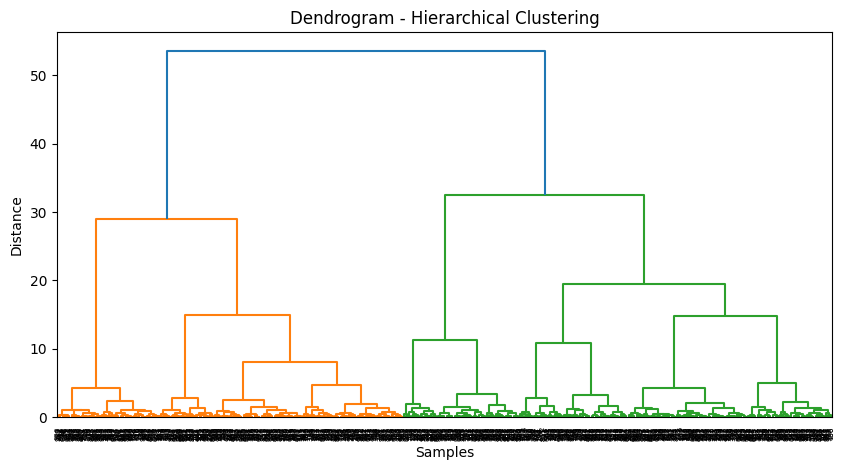

In [1435]:
plt.figure(figsize=(10,5))
dendrogram(linkage(X_pca, method='ward'))
plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [1436]:
hier = AgglomerativeClustering(n_clusters=3, linkage='ward')
hier_labels = hier.fit_predict(X_pca)

print("Hierarchical Silhouette Score:", silhouette_score(X_pca, hier_labels))

Hierarchical Silhouette Score: 0.46356228671377564


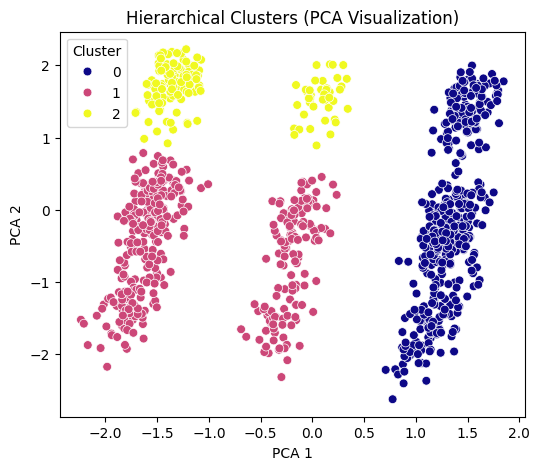

In [1437]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=hier_labels, palette='plasma', s=40)
plt.title('Hierarchical Clusters (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [1438]:
df['Hierarchical_Cluster'] = hier_labels

hier_descriptions = {
    0: "Short-distance rides with lower fares, mostly during calm traffic.",
    1: "Medium-length city trips under typical traffic conditions.",
    2: "Longer trips with higher fares, possibly evening or intercity rides."
}

df['Hierarchical_Description'] = df['Hierarchical_Cluster'].map(hier_descriptions)

In [1439]:
print("Cluster Counts:\n", df['Hierarchical_Cluster'].value_counts(), "\n")

print("Cluster Descriptions:")
for cluster, desc in hier_descriptions.items():
    print(f"Cluster {cluster}: {desc}")

Cluster Counts:
 Hierarchical_Cluster
0    447
1    403
2    150
Name: count, dtype: int64 

Cluster Descriptions:
Cluster 0: Short-distance rides with lower fares, mostly during calm traffic.
Cluster 1: Medium-length city trips under typical traffic conditions.
Cluster 2: Longer trips with higher fares, possibly evening or intercity rides.


DBSCAN Clustering

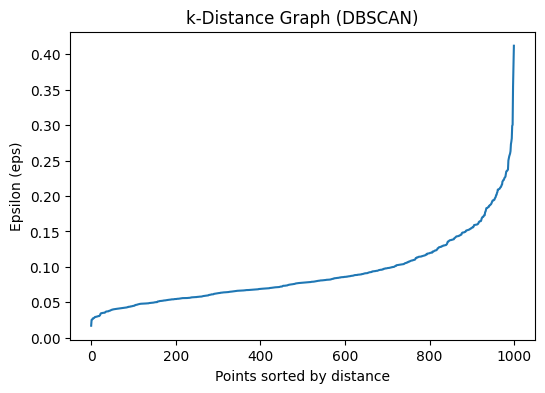

In [1440]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title('k-Distance Graph (DBSCAN)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon (eps)')
plt.show()

In [1441]:
dbscan = DBSCAN(eps=0.15, min_samples=5)
db_labels = dbscan.fit_predict(X_pca)

valid_mask = db_labels != -1
if len(set(db_labels[valid_mask])) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(X_pca[valid_mask], db_labels[valid_mask]))
else:
    print("DBSCAN Silhouette Score: Not applicable (too much noise)")

DBSCAN Silhouette Score: 0.5398155180935825


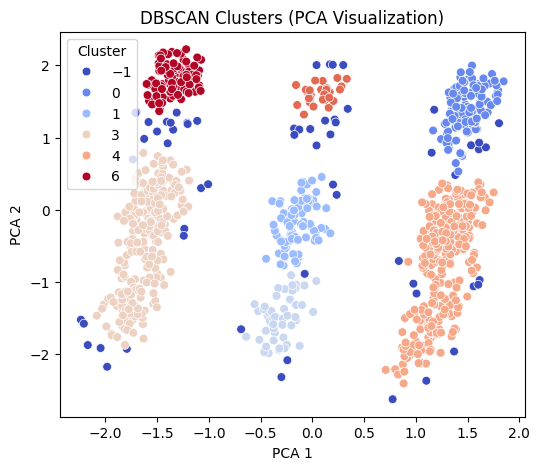

In [1442]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_labels, palette='coolwarm', s=40)
plt.title('DBSCAN Clusters (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [1443]:
df['DBSCAN_Cluster'] = db_labels

dbscan_descriptions = {
    0: "Regular city rides with average distance and fare.",
    1: "Short, dense rides — possibly in heavy traffic zones.",
    2: "Late-night or long-duration rides with higher fares.",
    3: "Moderate city rides, consistent pricing patterns.",
    4: "Frequent commuter trips with stable fares and short distances.",
    5: "High-end or intercity rides — rare and expensive.",
    6: "Compact trips during off-peak hours with low fares.",
    -1: "Noise points — irregular or outlier rides not fitting clusters."
}

df['DBSCAN_Description'] = df['DBSCAN_Cluster'].map(dbscan_descriptions)

In [1444]:
print("Cluster Counts:\n", df['DBSCAN_Cluster'].value_counts(), "\n")

print("Cluster Descriptions:")
for cluster, desc in dbscan_descriptions.items():
    print(f"Cluster {cluster}: {desc}")

Cluster Counts:
 DBSCAN_Cluster
 4    305
 3    253
 0    125
 6     94
 1     82
-1     61
 2     51
 5     29
Name: count, dtype: int64 

Cluster Descriptions:
Cluster 0: Regular city rides with average distance and fare.
Cluster 1: Short, dense rides — possibly in heavy traffic zones.
Cluster 2: Late-night or long-duration rides with higher fares.
Cluster 3: Moderate city rides, consistent pricing patterns.
Cluster 4: Frequent commuter trips with stable fares and short distances.
Cluster 5: High-end or intercity rides — rare and expensive.
Cluster 6: Compact trips during off-peak hours with low fares.
Cluster -1: Noise points — irregular or outlier rides not fitting clusters.


In [1445]:
import pickle

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('hierarchical_model.pkl', 'wb') as f:
    pickle.dump(hier, f)

with open('dbscan_model.pkl', 'wb') as f:
    pickle.dump(dbscan, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ All models and preprocessing objects saved successfully!")

✅ All models and preprocessing objects saved successfully!
